In [270]:
#Refer to https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6
#Refer to: https://github.com/JanSchm/CapMarket/blob/master/bot_experiments/IBM_Transformer%2BTimeEmbedding.ipynb
#Train and then validate and test the model

In [271]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.9.1


## Hyperparameters

In [272]:
batch_size = 32
seq_len = 43 # seq_len=43 意思是用43天的数据预测第44天后的趋势
column_len = 6 #the number of column
predict_column = 5 #which column to be predict, from 0 to column_len-1
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

#
stock_id = '601519'
stock_price_path = 'stockData/' + stock_id + '.csv'
train_from_scratch = True  # True: Train the model, False: Use the pre-train checkpoints

In [273]:
#Load data from DB to csv file
import psycopg2
import numpy
from psycopg2.extensions import register_adapter, AsIs
def addapt_numpy_float32(numpy_float32):
    return AsIs(numpy_float32)
def addapt_numpy_float64(numpy_float64):
    return AsIs(numpy_float64)
def addapt_numpy_int64(numpy_int64):
    return AsIs(numpy_int64)
register_adapter(numpy.float32, addapt_numpy_float32)
register_adapter(numpy.float64, addapt_numpy_float64)
register_adapter(numpy.int64, addapt_numpy_int64)


#Establishing the connection
conn = psycopg2.connect(
   database="easystogu", user='postgres', password='postgres', host='192.168.10.200', port= '5432'
)
#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

query = "select date,open,high,low,close,Volume from qian_fuquan_stockprice where stockid='" + stock_id + "' order by date"

outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query)

with open(stock_price_path, 'w') as f:
    cursor.copy_expert(outputquery, f)    

# Closing the connection
conn.close()

#Remove the first record, since it has big price change and will impact the AI
lines = []

with open(stock_price_path, 'r') as f:
    lines = f.readlines()

#Append the predict mock date price:     
latest_record = lines[len(lines)-1]
#Replace the latest record date to 9999-01-01 and append it to the last line of file
latest_record = '9999-01-01' + latest_record[10:]    
    
with open(stock_price_path, 'w') as f:
    f.writelines(lines[:1] + lines[2:] + list(latest_record)) 

## Load data

In [274]:
df = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])

# Replace 0 to avoid dividing by 0 later on
df['volume'].replace(to_replace=0, method='ffill', inplace=True) 

# the max close price in next 19 days
df['Max_Close_Price_In_Next_N_Days'] = df['close'].rolling(20).max().shift(-19)
# the close price after 10 days
df['Close_Price_After_N_Days'] = df['close'].shift(-19)

# Close price is less than the max close price after 19 days
df['Max_Close_Diff'] = df['Max_Close_Price_In_Next_N_Days'] - df['close']
df['Close_Diff'] = df['Close_Price_After_N_Days'] - df['close']

# Result should be a predict number, 1 means the price trend is increase 
# (the max close and close within next 10 days is higher then current price)

df['Result'] = 0
df.loc[(df['Max_Close_Diff'] > 0) & (df['Close_Diff'] > 0), ['Result']] = 1

df.sort_values('date', inplace=True)
df.tail(50)

,date,open,high,low,close,volume,Max_Close_Price_In_Next_N_Days,Close_Price_After_N_Days,Max_Close_Diff,Close_Diff,Result
2776,2023-03-23,6.48,6.85,6.48,6.79,612537,8.50,6.88,1.71,0.09,1
2777,2023-03-24,6.73,6.98,6.69,6.85,607652,8.50,6.67,1.65,-0.18,0
2778,2023-03-27,6.83,7.25,6.79,6.96,791469,8.50,6.54,1.54,-0.42,0
2779,2023-03-28,6.84,7.13,6.69,6.91,669984,8.50,7.19,1.59,0.28,1
2780,2023-03-29,6.86,7.06,6.80,6.86,365773,8.50,7.52,1.64,0.66,1
2781,2023-03-30,6.83,6.90,6.64,6.79,343074,8.50,7.63,1.71,0.84,1
2782,2023-03-31,6.75,6.95,6.68,6.91,358638,8.50,7.68,1.59,0.77,1
2783,2023-04-03,6.91,7.40,6.84,7.29,1053760,8.50,7.86,1.21,0.57,1
2784,2023-04-04,7.25,8.02,7.23,8.02,1575668,8.50,7.66,0.48,-0.36,0
2785,2023-04-06,7.95,8.10,7.55,7.73,1535393,8.50,7.70,0.77,-0.03,0


In [275]:
print('Drop temp column, do not use them for training and testing')
del df['Max_Close_Diff']
del df['Close_Diff']
del df['Close_Price_After_N_Days']
del df['Max_Close_Price_In_Next_N_Days']

df.tail()

Drop temp column, do not use them for training and testing


,date,open,high,low,close,volume,Result
2821,2023-06-06,7.42,7.46,7.11,7.15,405020,0
2822,2023-06-07,7.15,7.35,7.13,7.28,258654,0
2823,2023-06-08,7.25,7.37,7.11,7.29,293411,0
2824,2023-06-09,7.29,7.31,7.15,7.30,229436,0
2825,9999-01-01,7.29,7.31,7.15,7.30,229436,0


## Plot daily closing prices and volume

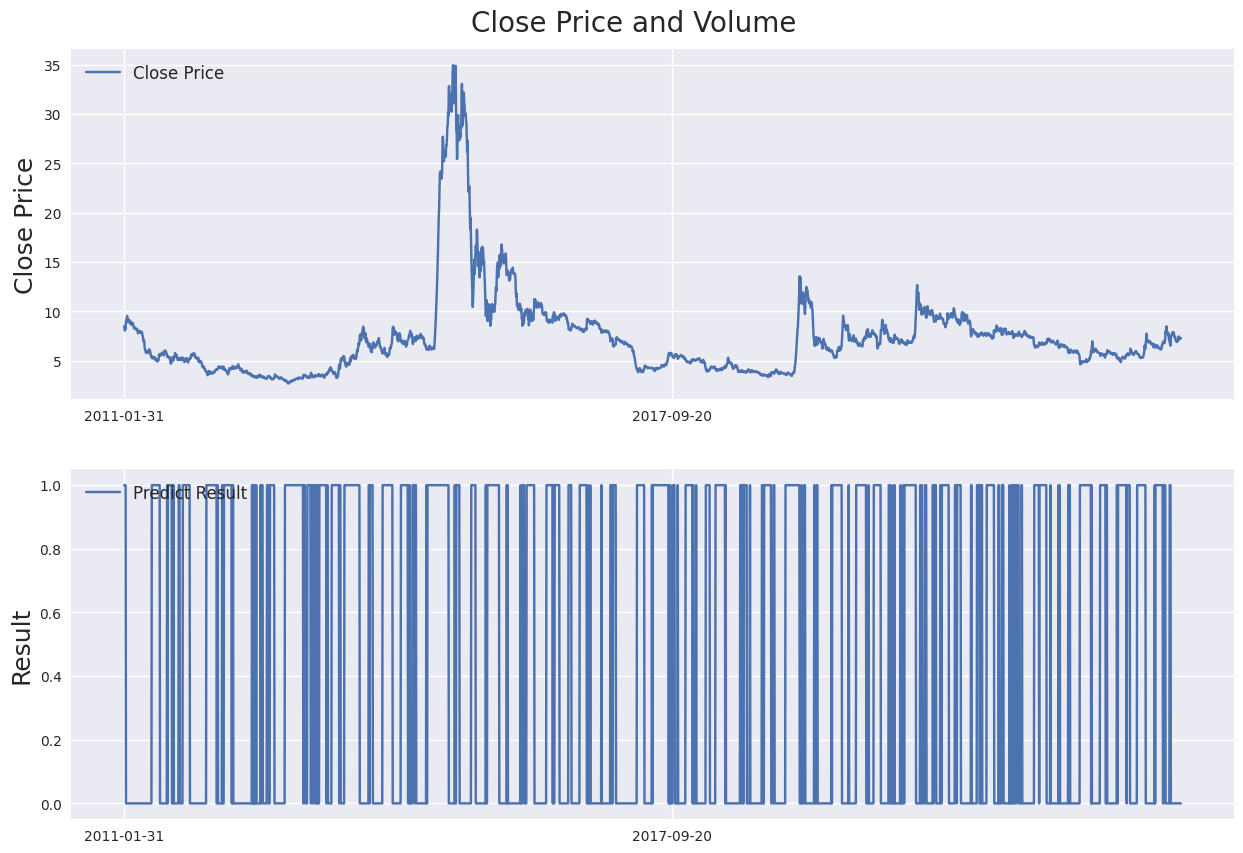

In [276]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['close'], label='Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Result'], label='Predict Result')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['date'].loc[::1464])
ax2.set_ylabel('Result', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)
plt.show()

## Calculate normalized percentage change of all columns

In [277]:
'''Calculate percentage change'''

df['open'] = df['open'].pct_change() # Create arithmetic returns column
df['high'] = df['high'].pct_change() # Create arithmetic returns column
df['low'] = df['low'].pct_change() # Create arithmetic returns column
df['close'] = df['close'].pct_change() # Create arithmetic returns column
df['volume'] = df['volume'].pct_change()
#df['Result'] = df['Result'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['open'] = (df['open'] - min_return) / (max_return - min_return)
df['high'] = (df['high'] - min_return) / (max_return - min_return)
df['low'] = (df['low'] - min_return) / (max_return - min_return)
df['close'] = (df['close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['volume'] = (df['volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Normalize Result column'''

min_result = df[(df.index < last_20pct)]['Result'].min(axis=0)
max_result = df[(df.index < last_20pct)]['Result'].max(axis=0)

# Min-max normalize Result columns (0-1 range)
df['Result'] = (df['Result'] - min_result) / (max_result - min_result)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]
df_test_with_date = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['date'], inplace=True)
df_val.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
test_data_with_date = df_test_with_date.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.tail(50)

Training data shape: (2260, 6)
Validation data shape: (283, 6)
Test data shape: (282, 6)


,open,high,low,close,volume,Result
2211,0.442203,0.527899,0.412083,0.471827,0.034751,0.0
2212,0.452805,0.386025,0.496792,0.406743,0.007447,0.0
2213,0.459079,0.438078,0.393283,0.389139,0.013558,0.0
2214,0.327129,0.363658,0.402983,0.431309,0.010640,0.0
2215,0.466585,0.450800,0.446646,0.486014,0.011433,0.0
2216,0.521062,0.583461,0.530865,0.465796,0.045449,0.0
2217,0.444313,0.438199,0.427330,0.531259,0.012290,0.0
2218,0.520174,0.516439,0.536375,0.488944,0.015901,0.0
2219,0.440173,0.391859,0.442203,0.414386,0.007350,0.0
2220,0.427978,0.386623,0.391044,0.379762,0.009055,0.0


## Plot daily changes of close prices and volume

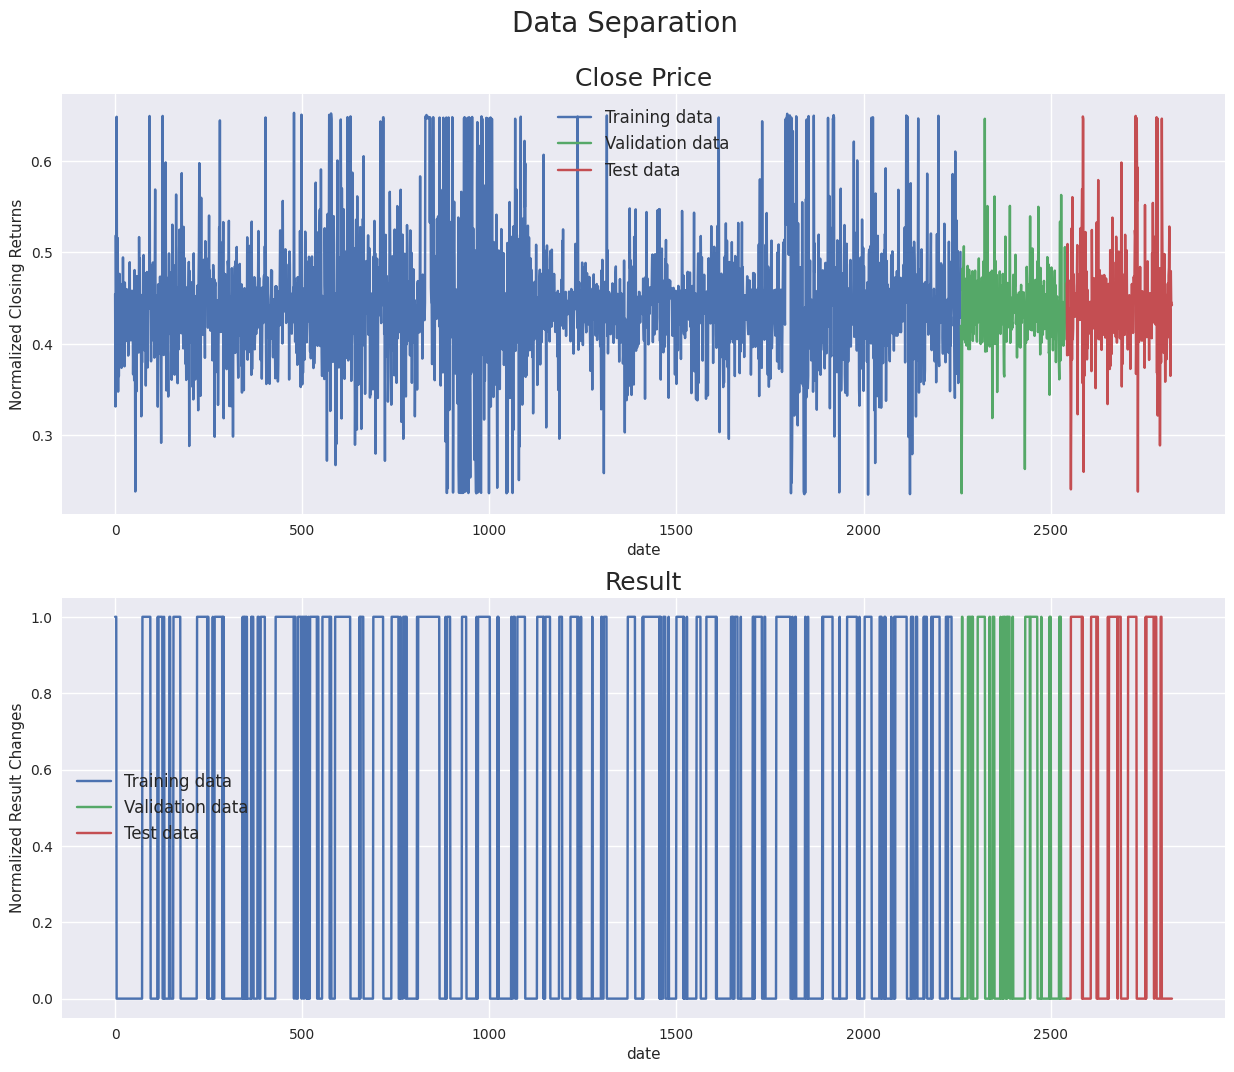

In [278]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['close'], label='Test data')
ax1.set_xlabel('date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Result'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Result'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Result'], label='Test data')
ax2.set_xlabel('date')
ax2.set_ylabel('Normalized Result Changes')
ax2.set_title("Result", fontsize=18)
ax2.legend(loc="best", fontsize=12)
plt.show()

## Create chunks of training, validation and test data

In [279]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  #y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
  y_train.append(train_data[:, predict_column][i]) #Value of 6th column (Result) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, predict_column][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
X_test_with_data, X_test_last_43 = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    X_test_with_data.append(test_data_with_date[i-seq_len:i])
    y_test.append(test_data[:, predict_column][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

X_test_with_data = np.array(X_test_with_data)
X_test_last_43 = X_test[-1:]
X_test_with_date_last_43 = X_test_with_data[-1:]

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)
#print(X_test.shape, y_test.shape)
#print(X_test_with_date_last_43.shape)
#print(X_test_with_date_last_43)

Training set shape (2217, 43, 6) (2217,)
Validation set shape (240, 43, 6) (240,)
Testing set shape (239, 43, 6) (239,)


## Model

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 43, 6)]      0           []                               
                                                                                                  
 time2_vector_22 (Time2Vector)  (None, 43, 2)        172         ['input_23[0][0]']               
                                                                                                  
 concatenate_22 (Concatenate)   (None, 43, 8)        0           ['input_23[0][0]',               
                                                                  'time2_vector_22[0][0]']        
                                                                                                  
 transformer_encoder_66 (Transf  (None, 43, 8)       111920      ['concatenate_22[0][0]',  

Epoch 13/20
70/70 [==============================] - ETA: 0s - loss: 0.3145 - mae: 0.1830 - mape: 92302936.0000
Epoch 13: val_loss did not improve from 0.36928
70/70 [==============================] - 16s 232ms/step - loss: 0.3145 - mae: 0.1830 - mape: 92302936.0000 - val_loss: 0.3720 - val_mae: 0.1810 - val_mape: 86444496.0000
Epoch 14/20
70/70 [==============================] - ETA: 0s - loss: 0.3102 - mae: 0.1794 - mape: 88439328.0000
Epoch 14: val_loss did not improve from 0.36928
70/70 [==============================] - 16s 231ms/step - loss: 0.3102 - mae: 0.1794 - mape: 88439328.0000 - val_loss: 0.3788 - val_mae: 0.1772 - val_mape: 85892960.0000
Epoch 15/20
70/70 [==============================] - ETA: 0s - loss: 0.3143 - mae: 0.1763 - mape: 84364456.0000
Epoch 15: val_loss did not improve from 0.36928
70/70 [==============================] - 16s 232ms/step - loss: 0.3143 - mae: 0.1763 - mape: 84364456.0000 - val_loss: 0.3749 - val_mae: 0.2241 - val_mape: 143712656.0000
Epoch 16/

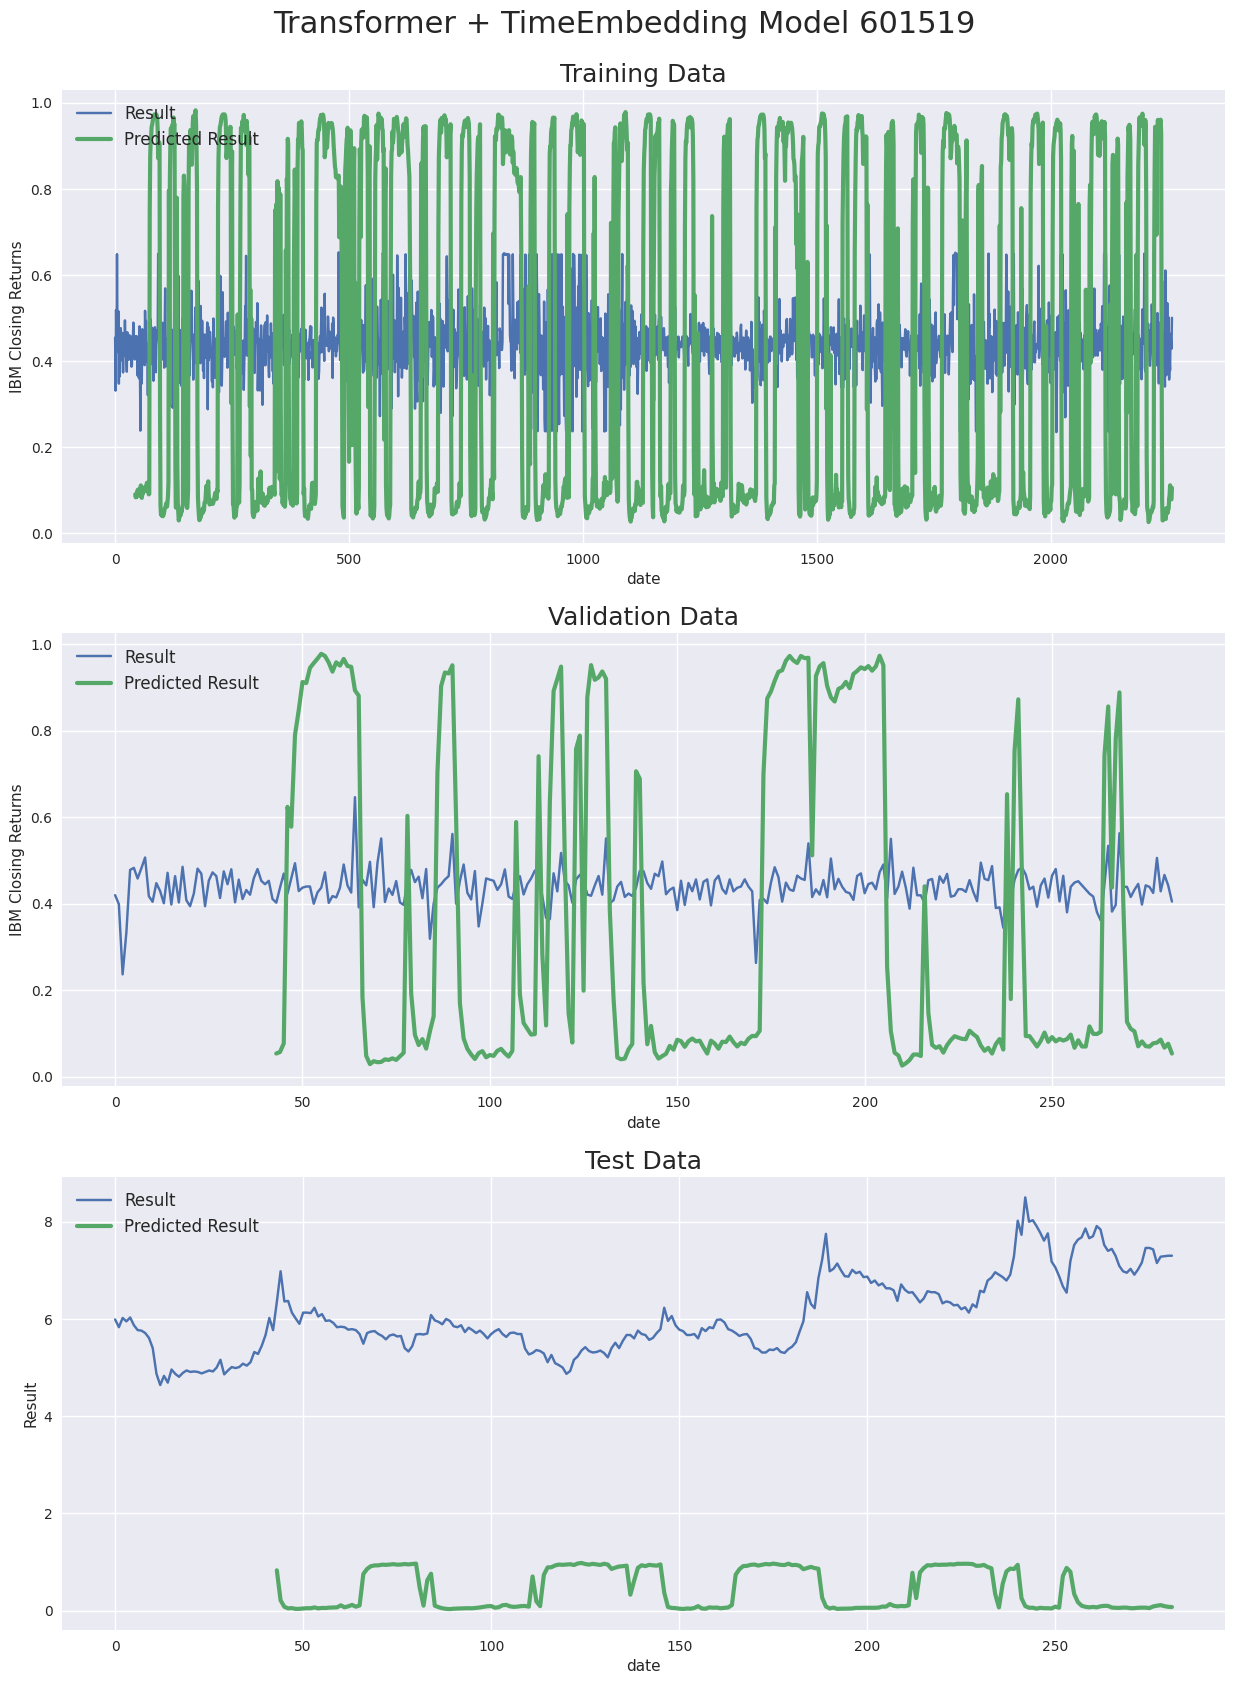

In [280]:
from model.transformer import TransformerEncoder
from model.transformer import Time2Vector
from model.transformer import MultiAttention
from model.transformer import SingleAttention

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, column_len))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  #out = Dense(1, activation='linear')(x) #predict the price
  out = Dense(1, activation='sigmoid')(x) #predict 1 or 0

  model = Model(inputs=in_seq, outputs=out)
  #model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape']) #linear use mse
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'mape'])#sigmoid use binary_crossentropy
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('./checkpoints/Transformer+TimeEmbedding_' + stock_id + '.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

if train_from_scratch:
    history = model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=20, 
                        callbacks=[callback],
                        validation_data=(X_val, y_val))  
else:
    model = tf.keras.models.load_model('./checkpoints/Transformer+TimeEmbedding_' + stock_id + '.hdf5',
                                       custom_objects={'Time2Vector': Time2Vector, 
                                                       'SingleAttention': SingleAttention,
                                                       'MultiAttention': MultiAttention,
                                                       'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''
df2 = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
df2.sort_values('date', inplace=True)
df2_close = df2['close'].values
df2_close_price = df2_close[-len(test_data):]

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model " + stock_id, fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Result')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Result')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Result')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Result')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
#ax31.plot(test_data[:, 3], label='Result')
ax31.plot(df2_close_price, label='Result')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Result')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('date')
ax31.set_ylabel('Result')
ax31.legend(loc="best", fontsize=12)
plt.show()

## Model metrics

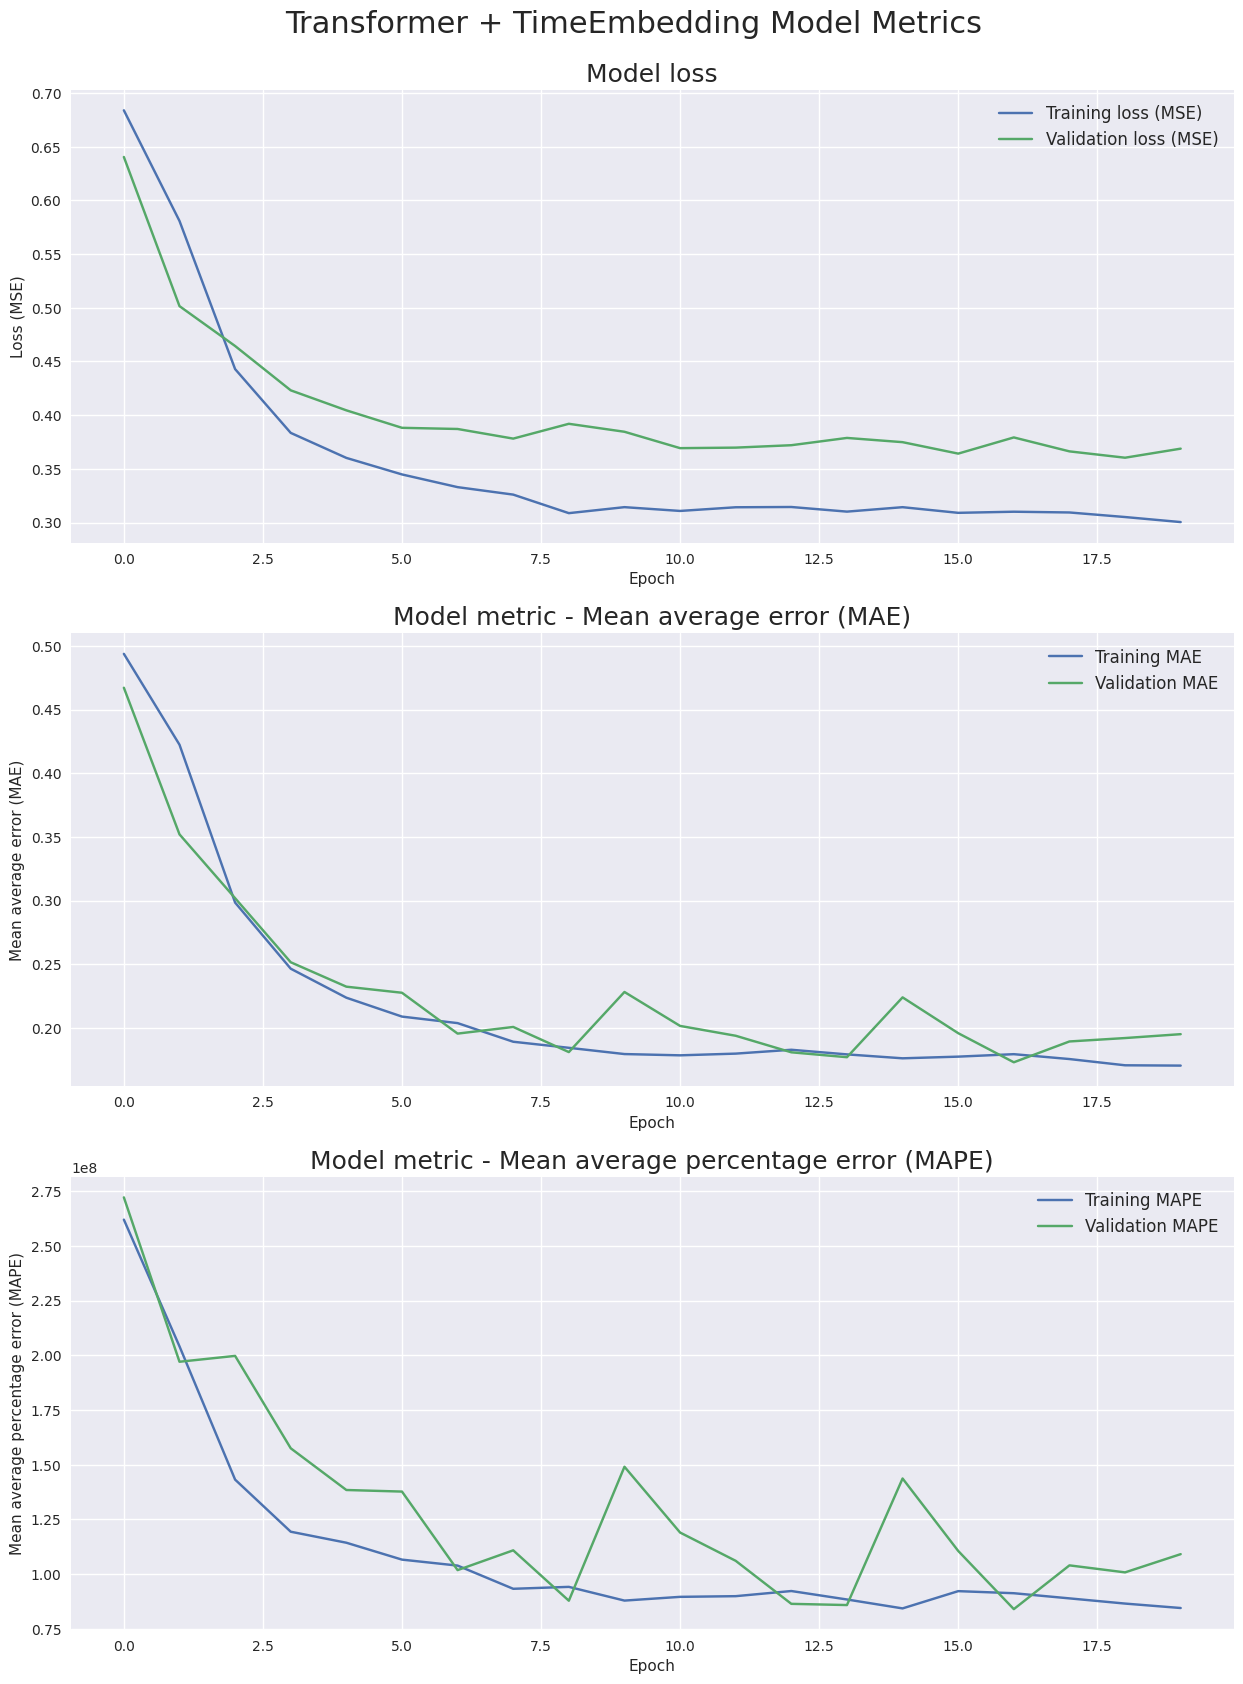

In [281]:
'''Display model metrics'''
if train_from_scratch:
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
    st.set_y(0.92)

    #Plot model loss
    ax1 = fig.add_subplot(311)
    ax1.plot(history.history['loss'], label='Training loss (MSE)')
    ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
    ax1.set_title("Model loss", fontsize=18)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend(loc="best", fontsize=12)

    #Plot MAE
    ax2 = fig.add_subplot(312)
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean average error (MAE)')
    ax2.legend(loc="best", fontsize=12)

    #Plot MAPE
    ax3 = fig.add_subplot(313)
    ax3.plot(history.history['mape'], label='Training MAPE')
    ax3.plot(history.history['val_mape'], label='Validation MAPE')
    ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Mean average percentage error (MAPE)')
    ax3.legend(loc="best", fontsize=12)
    plt.show()

## Model architecture overview

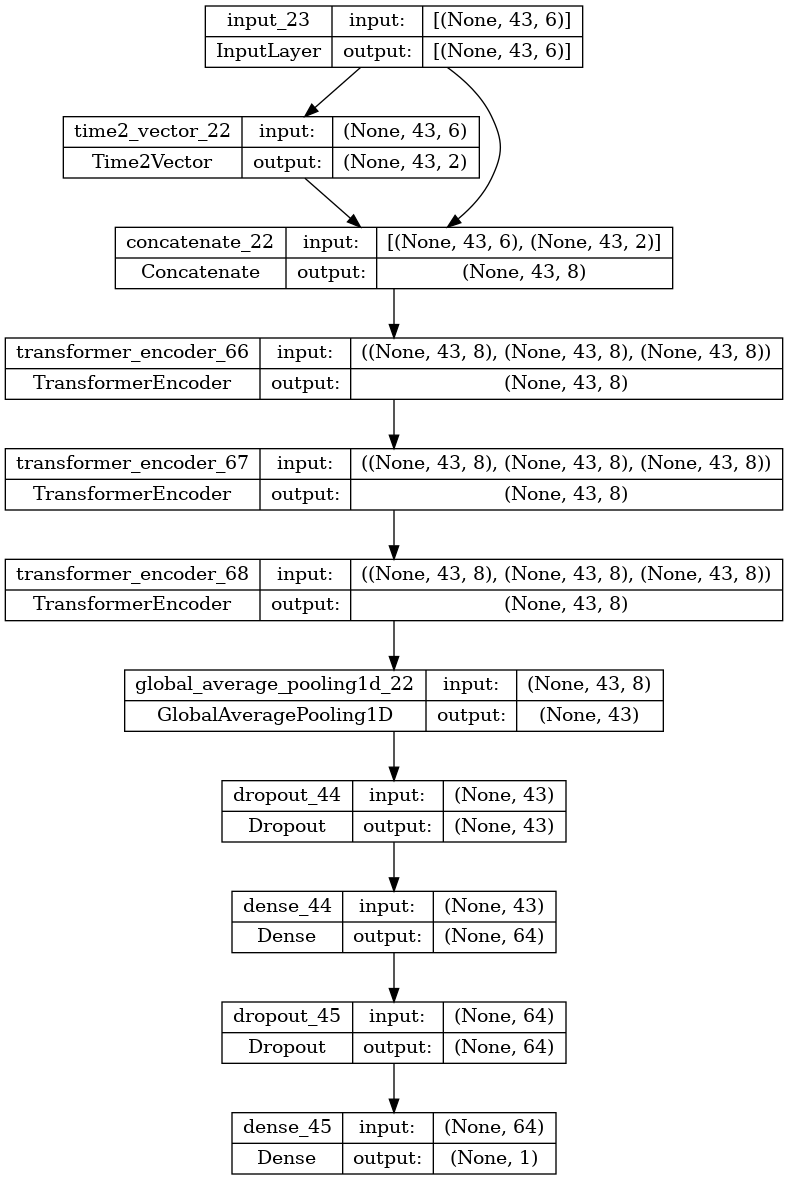

In [282]:
tf.keras.utils.plot_model(
    model,
    to_file="Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

# Moving Average

## Moving Average - Load data again, to apply rolling window

In [283]:
df = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])

# Replace 0 to avoid dividing by 0 later on
df['volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('date', inplace=True)


# Apply moving average with a window of 10 days to all columns
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].rolling(10).mean() 

# the max close price in next 19 days
df['Max_Close_Price_In_Next_N_Days'] = df['close'].rolling(20).max().shift(-19)
# the close price after 10 days
df['Close_Price_After_N_Days'] = df['close'].shift(-19)

# Close price is less than the max close price after 19 days
df['Max_Close_Diff'] = df['Max_Close_Price_In_Next_N_Days'] - df['close']
df['Close_Diff'] = df['Close_Price_After_N_Days'] - df['close']

# Result should be a predict number, 1 means the price trend is increase 
# (the max close and close within next 10 days is higher then current price)

df['Result'] = 0
df.loc[(df['Max_Close_Diff'] > 0) & (df['Close_Diff'] > 0), ['Result']] = 1

del df['Max_Close_Diff']
del df['Close_Diff']
del df['Close_Price_After_N_Days']
del df['Max_Close_Price_In_Next_N_Days']

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()

,date,open,high,low,close,volume,Result
9,2011-02-18,8.708,9.016,8.556,8.786,231142.7,0
10,2011-02-21,8.743,9.070,8.611,8.864,208727.1,0
11,2011-02-22,8.814,9.125,8.657,8.902,194010.8,0
12,2011-02-23,8.889,9.207,8.754,8.996,180348.5,0
13,2011-02-24,8.987,9.283,8.847,9.075,170386.8,0


## Moving Average - Plot daily closing prices and volume

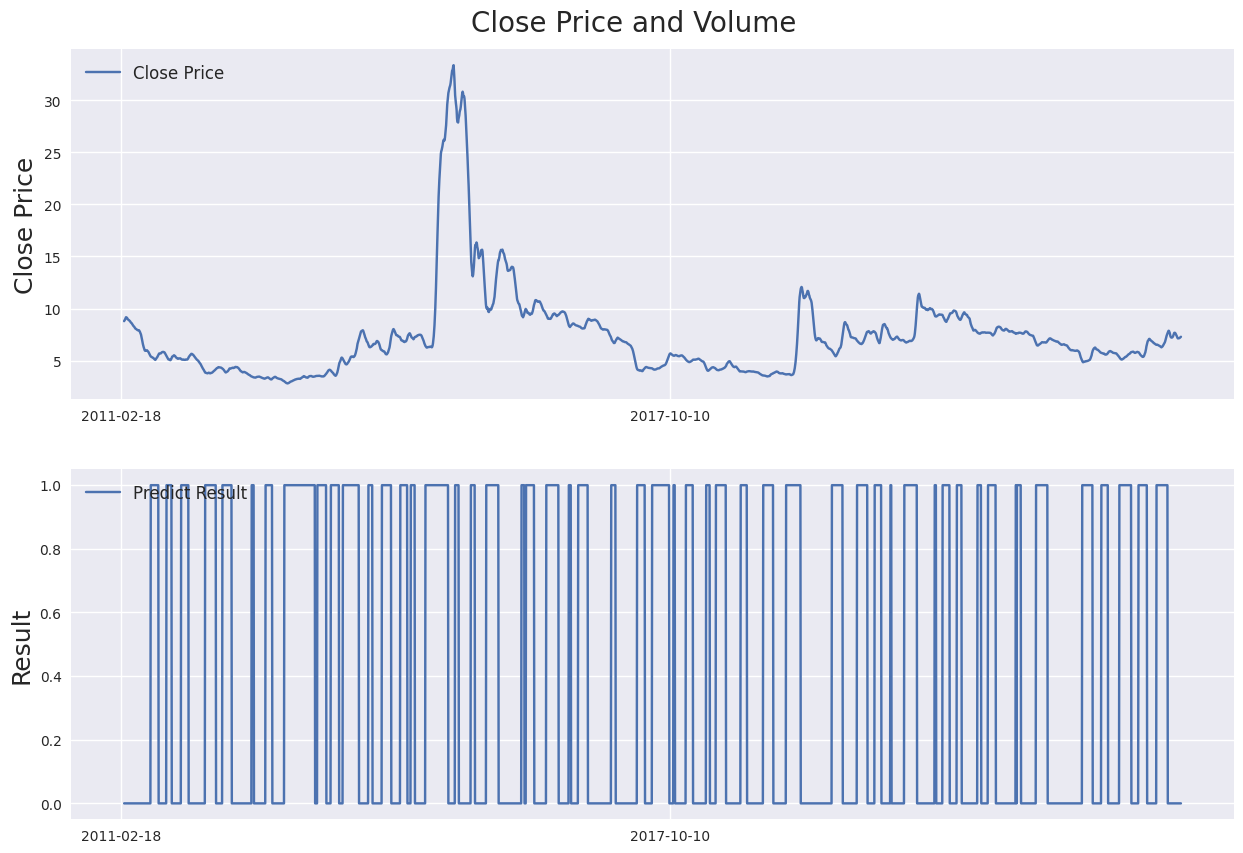

In [284]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['close'], label='Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Result'], label='Predict Result')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['date'].loc[::1464])
ax2.set_ylabel('Result', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)
plt.show()

## Moving Average - Calculate normalized percentage change for all columns

In [285]:
'''Calculate percentage change'''

df['open'] = df['open'].pct_change() # Create arithmetic returns column
df['high'] = df['high'].pct_change() # Create arithmetic returns column
df['low'] = df['low'].pct_change() # Create arithmetic returns column
df['close'] = df['close'].pct_change() # Create arithmetic returns column
df['volume'] = df['volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['open'] = (df['open'] - min_return) / (max_return - min_return)
df['high'] = (df['high'] - min_return) / (max_return - min_return)
df['low'] = (df['low'] - min_return) / (max_return - min_return)
df['close'] = (df['close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['volume'] = (df['volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Normalize Result column'''

min_result = df[(df.index < last_20pct)]['Result'].min(axis=0)
max_result = df[(df.index < last_20pct)]['Result'].max(axis=0)

# Min-max normalize Result columns (0-1 range)
df['Result'] = (df['Result'] - min_result) / (max_result - min_result)
###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]
df_test_with_date = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['date'], inplace=True)
df_val.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
test_data_with_date = df_test_with_date.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (2253, 6)
Validation data shape: (282, 6)
Test data shape: (281, 6)


,open,high,low,close,volume,Result
10,0.452613,0.463253,0.465624,0.478853,0.042208,0.0
11,0.474765,0.463656,0.459757,0.454059,0.047744,0.0
12,0.476863,0.479440,0.491422,0.487936,0.047761,0.0
13,0.490450,0.475488,0.488283,0.478335,0.050937,0.0
14,0.478983,0.483268,0.484628,0.483278,0.057793,0.0


## Moving Average - Plot daily changes of close price and volume

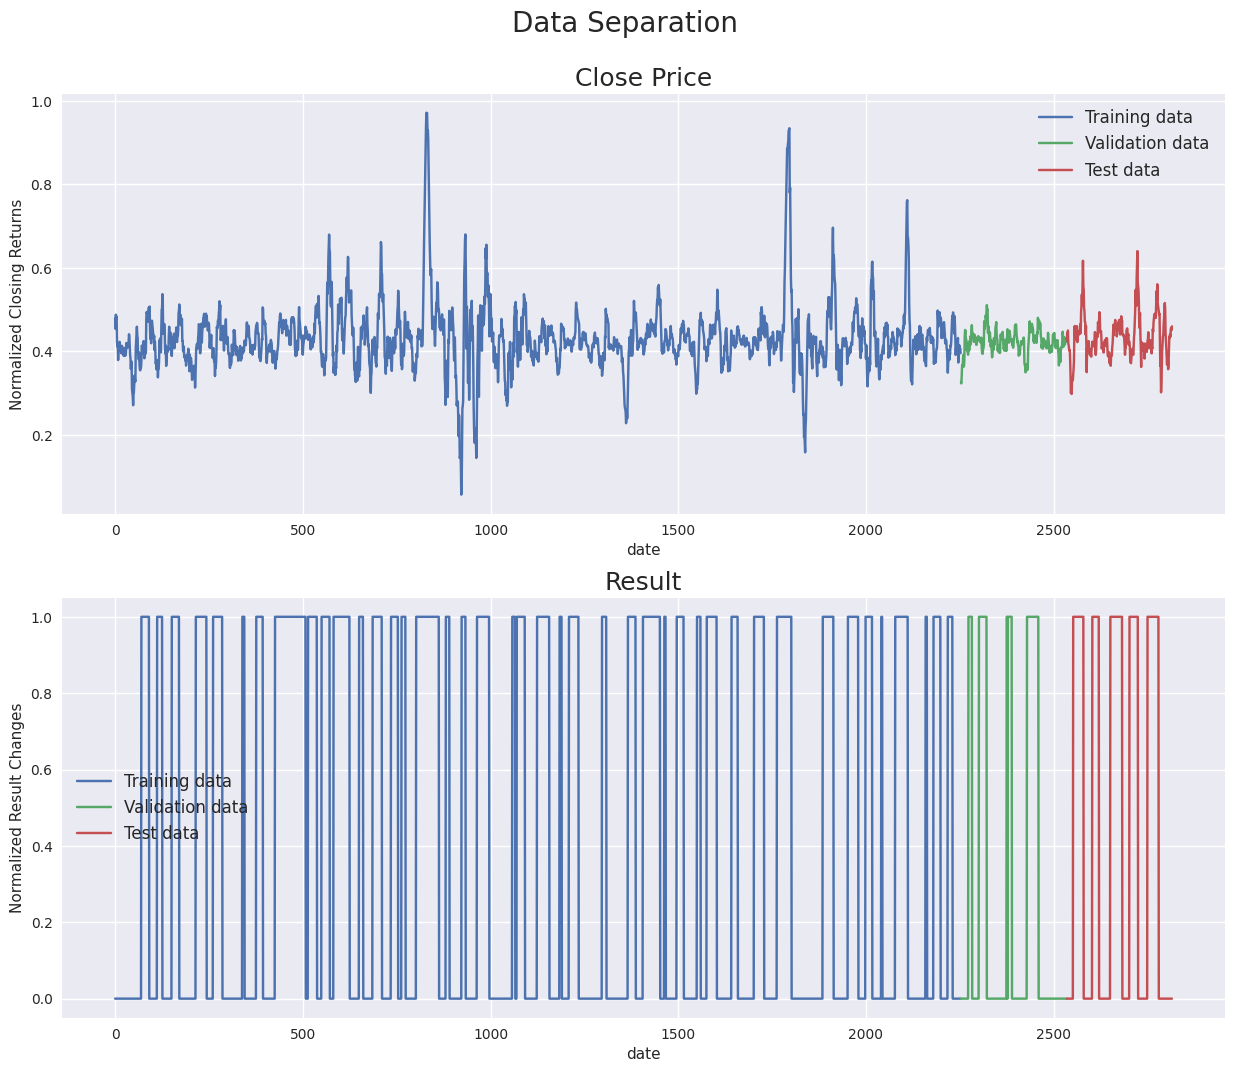

In [286]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['close'], label='Test data')
ax1.set_xlabel('date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Result'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Result'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Result'], label='Test data')
ax2.set_xlabel('date')
ax2.set_ylabel('Normalized Result Changes')
ax2.set_title("Result", fontsize=18)
ax2.legend(loc="best", fontsize=12)
plt.show()

## Moving Average - Create chunks of training, validation, and test data

In [287]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, predict_column][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, predict_column][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
X_test_with_data, X_test_last_43 = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    X_test_with_data.append(test_data_with_date[i-seq_len:i])
    y_test.append(test_data[:, predict_column][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

X_test_with_data = np.array(X_test_with_data)
X_test_last_43 = X_test[-1:]
X_test_with_date_last_43 = X_test_with_data[-1:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
#print(X_test_with_date_last_43.shape)
#print(X_test_with_date_last_43)

(2210, 43, 6) (2210,)
(239, 43, 6) (239,)
(238, 43, 6) (238,)


## Moving Average - Model

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 43, 6)]      0           []                               
                                                                                                  
 time2_vector_23 (Time2Vector)  (None, 43, 2)        172         ['input_24[0][0]']               
                                                                                                  
 concatenate_23 (Concatenate)   (None, 43, 8)        0           ['input_24[0][0]',               
                                                                  'time2_vector_23[0][0]']        
                                                                                                  
 transformer_encoder_69 (Transf  (None, 43, 8)       111920      ['concatenate_23[0][0]',  

70/70 [==============================] - 16s 231ms/step - loss: 0.1847 - mae: 0.0980 - mape: 51030712.0000 - val_loss: 0.1379 - val_mae: 0.0679 - val_mape: 39064772.0000
Epoch 13/20
69/70 [============================>.] - ETA: 0s - loss: 0.1908 - mae: 0.0983 - mape: 51732532.0000
Epoch 13: val_loss improved from 0.13751 to 0.13502, saving model to ./checkpoints/Transformer+TimeEmbedding_mean_601519.hdf5
70/70 [==============================] - 17s 238ms/step - loss: 0.1906 - mae: 0.0983 - mape: 51700488.0000 - val_loss: 0.1350 - val_mae: 0.0679 - val_mape: 38595048.0000
Epoch 14/20
69/70 [============================>.] - ETA: 0s - loss: 0.1870 - mae: 0.0991 - mape: 50579428.0000
Epoch 14: val_loss did not improve from 0.13502
70/70 [==============================] - 16s 232ms/step - loss: 0.1869 - mae: 0.0991 - mape: 50542440.0000 - val_loss: 0.1373 - val_mae: 0.0610 - val_mape: 33415676.0000
Epoch 15/20
69/70 [============================>.] - ETA: 0s - loss: 0.1884 - mae: 0.0931 - 

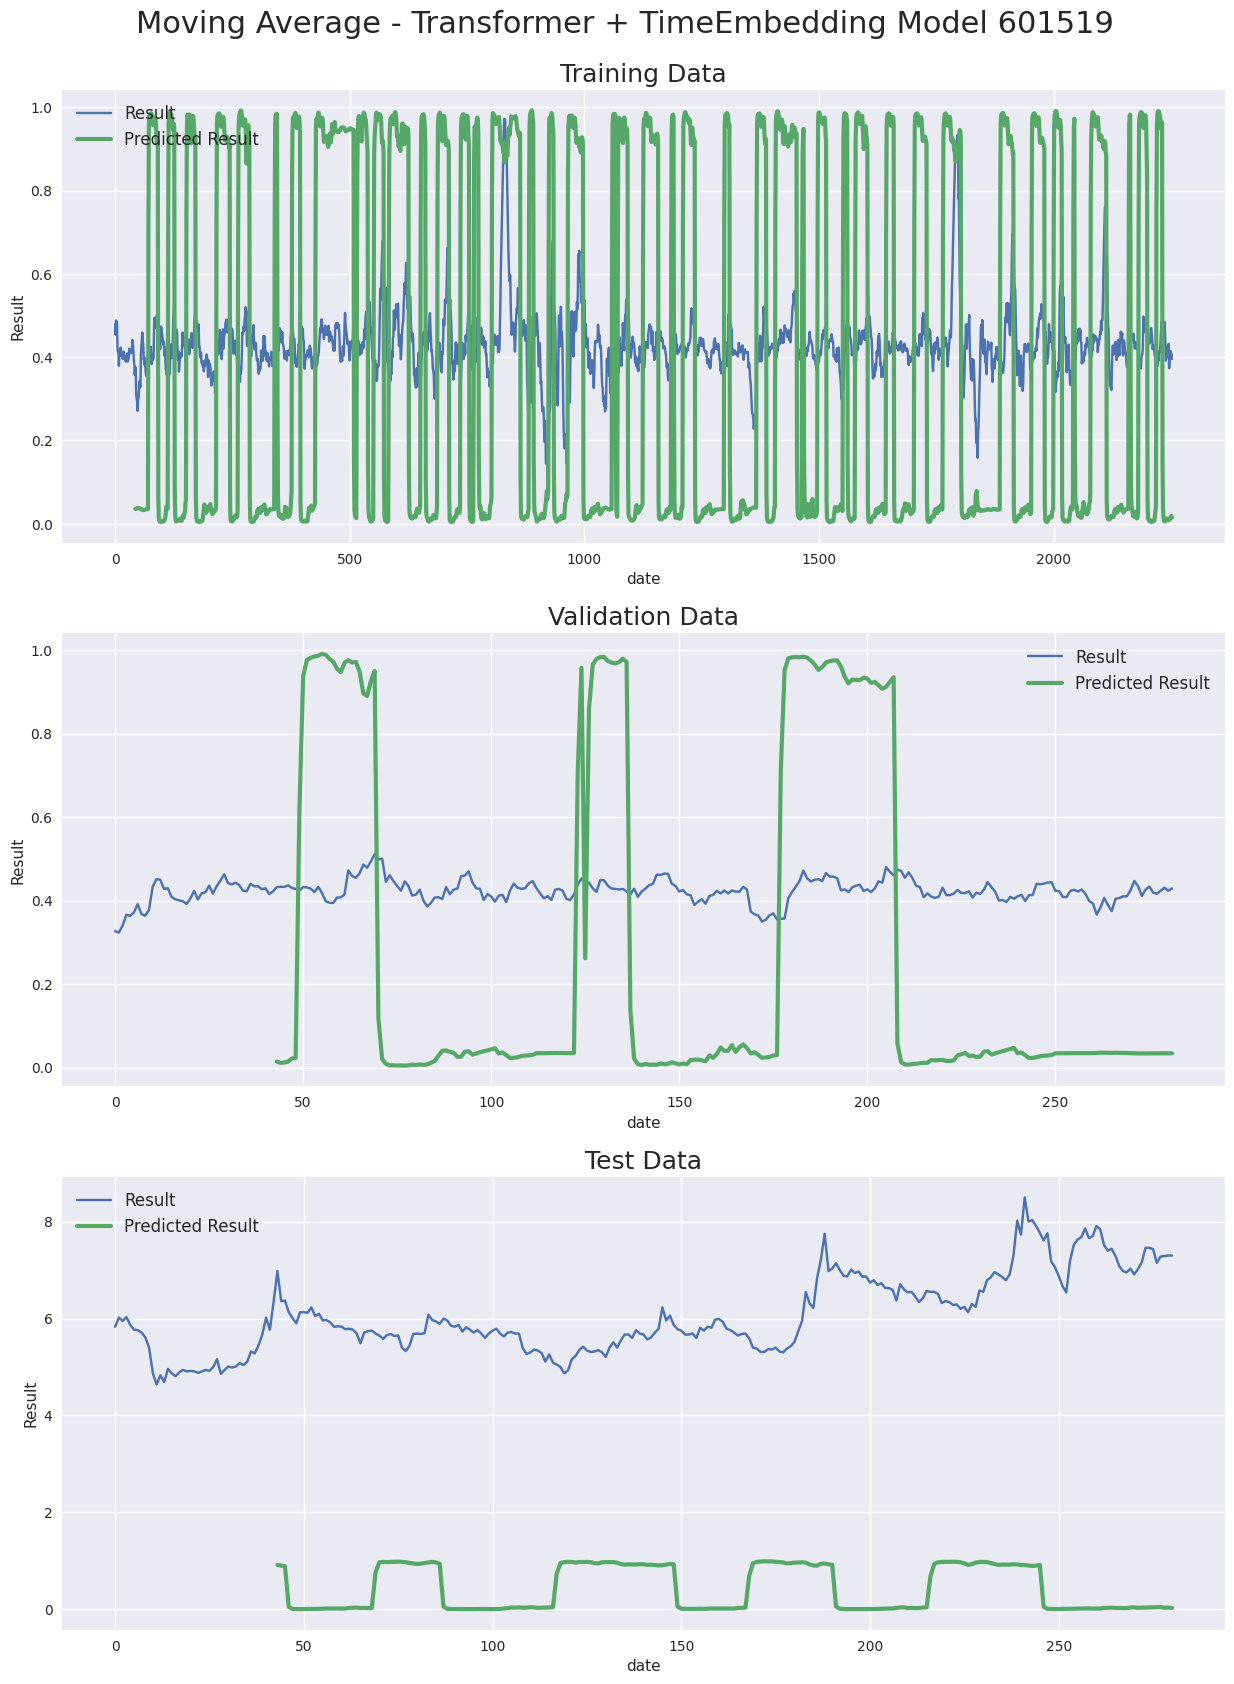

In [288]:
from model.transformer import TransformerEncoder
from model.transformer import Time2Vector
from model.transformer import MultiAttention
from model.transformer import SingleAttention

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, column_len))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  #out = Dense(1, activation='linear')(x)
  out = Dense(1, activation='sigmoid')(x) #predict 1 or 0

  model = Model(inputs=in_seq, outputs=out)
  #model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])#linear use mse
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'mape'])#sigmoid use binary_crossentropy
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('./checkpoints/Transformer+TimeEmbedding_mean_' + stock_id + '.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

if train_from_scratch:
    history = model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=20, 
                        callbacks=[callback],
                        validation_data=(X_val, y_val))  
else:
    model = tf.keras.models.load_model('./checkpoints/Transformer+TimeEmbedding_mean_' + stock_id + '.hdf5',
                                       custom_objects={'Time2Vector': Time2Vector, 
                                                       'SingleAttention': SingleAttention,
                                                       'MultiAttention': MultiAttention,
                                                       'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

df2 = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
df2.sort_values('date', inplace=True)
df2_close = df2['close'].values
df2_close_price = df2_close[-len(test_data):]

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model " + stock_id, fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Result')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Result')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('date')
ax11.set_ylabel('Result')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Result')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Result')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('date')
ax21.set_ylabel('Result')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
#ax31.plot(test_data[:, 3], label='Result')
ax31.plot(df2_close_price, label='Result')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Result')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('date')
ax31.set_ylabel('Result')
ax31.legend(loc="best", fontsize=12)
plt.show()

## Moving Average - Model metrics

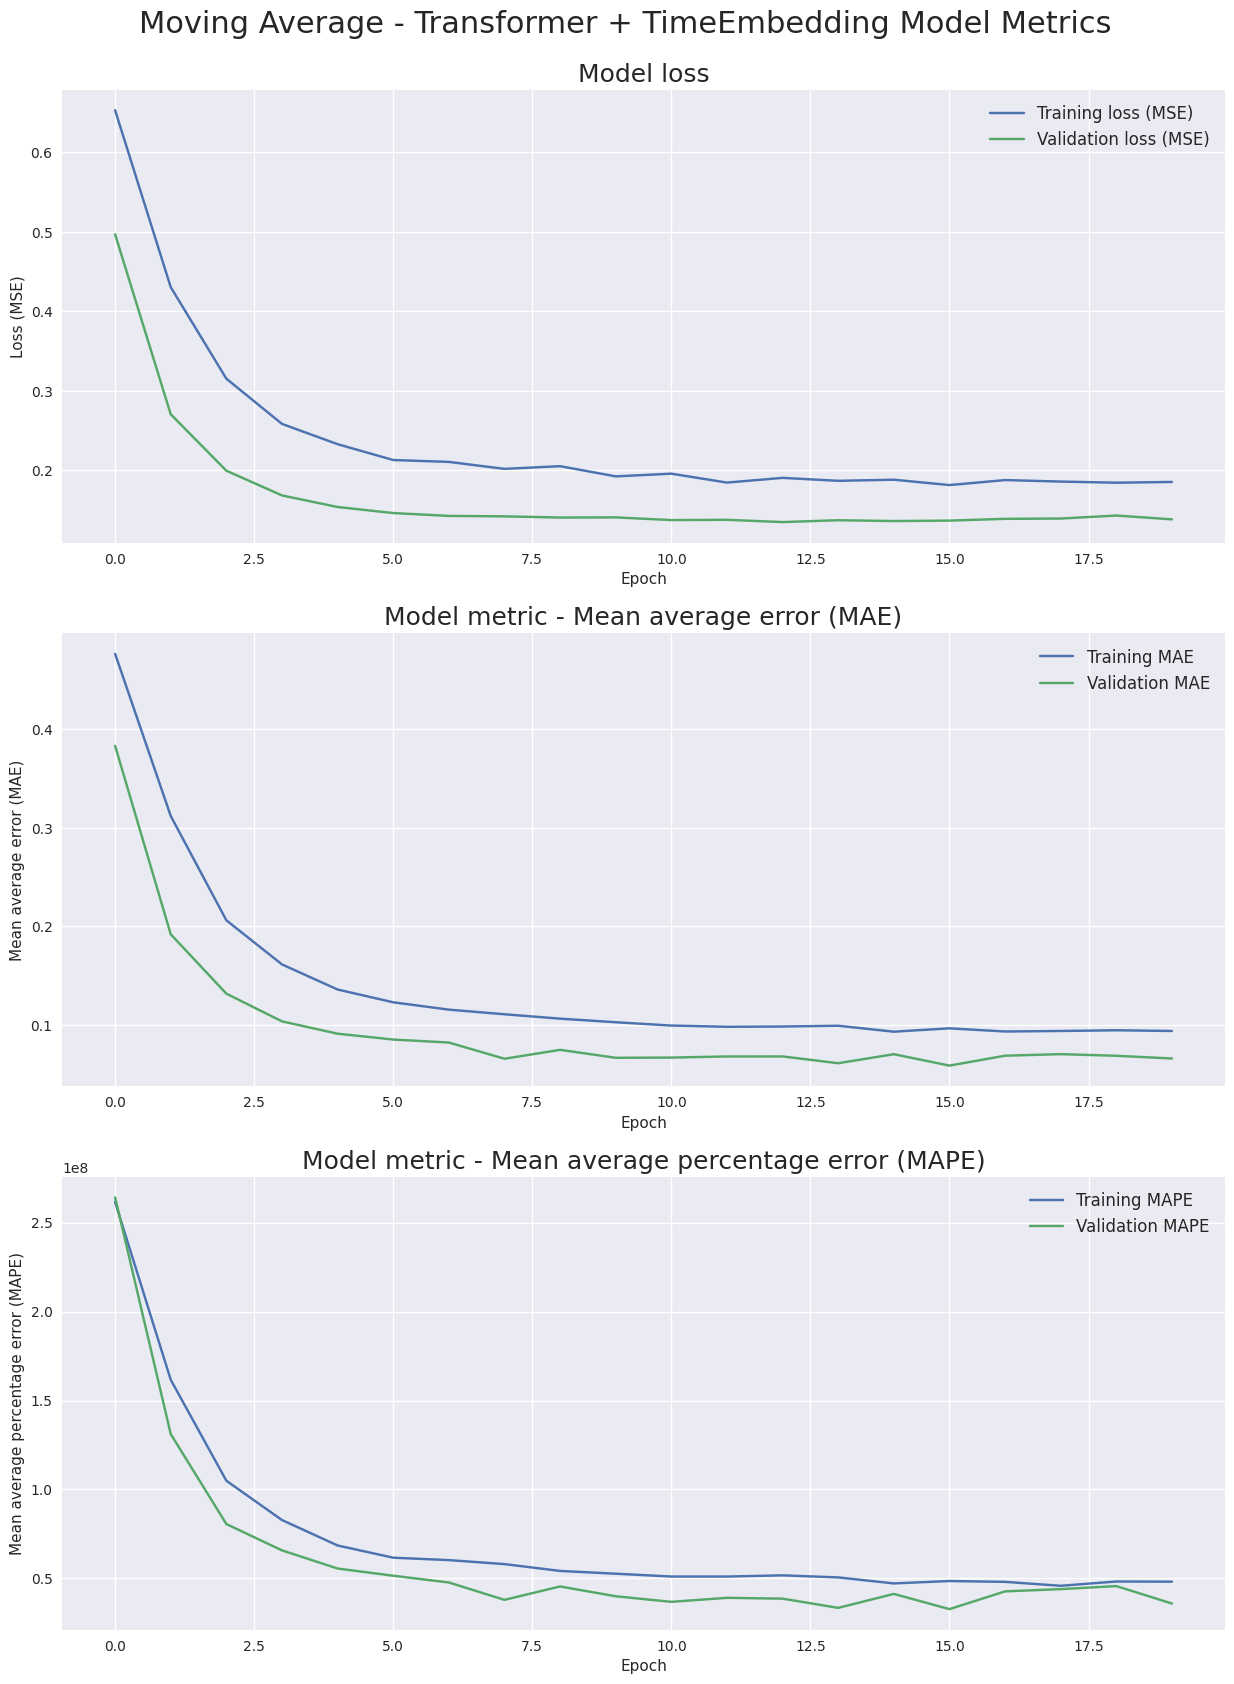

In [289]:
'''Display model metrics'''
if train_from_scratch:
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
    st.set_y(0.92)

    #Plot model loss
    ax1 = fig.add_subplot(311)
    ax1.plot(history.history['loss'], label='Training loss (MSE)')
    ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
    ax1.set_title("Model loss", fontsize=18)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend(loc="best", fontsize=12)

    #Plot MAE
    ax2 = fig.add_subplot(312)
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean average error (MAE)')
    ax2.legend(loc="best", fontsize=12)

    #Plot MAPE
    ax3 = fig.add_subplot(313)
    ax3.plot(history.history['mape'], label='Training MAPE')
    ax3.plot(history.history['val_mape'], label='Validation MAPE')
    ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Mean average percentage error (MAPE)')
    ax3.legend(loc="best", fontsize=12)
    plt.show()

In [290]:
#5. Analysis for the result (in progress)

#Because the prediction is calculated by Moving average and then normalziation, so we are trying to return the difference to the real world. \

#Here, we calculate the difference between real case and prediction, and compared with the real result.


In [291]:
print(X_test.shape, y_test.shape)
test_pred = model.predict(X_test)

print('len of test_pred:', len(test_pred))
df_test_with_date = df[(df.index >= last_10pct)]
df_test_with_date=df_test_with_date[-(len(df_test_with_date)-seq_len):]
print('len of df_test_with_date:', len(df_test_with_date))

print('last 60 of test_pred:',test_pred[-50:])
print('last 60 of df_test_with_date:',df_test_with_date['date'][-50:])

#for pred in test_pred:
#    print(pred)
#for date in df_test_with_date['date'].values:
#    print(date)

(238, 43, 6) (238,)
8/8 [==============================] - 1s 71ms/step
len of test_pred: 238
len of df_test_with_date: 238
last 60 of test_pred: [[0.97471935]
 [0.95482624]
 [0.93506014]
 [0.9162501 ]
 [0.9237681 ]
 [0.9229621 ]
 [0.92243284]
 [0.9296211 ]
 [0.9268288 ]
 [0.9139787 ]
 [0.91539574]
 [0.9039129 ]
 [0.8953964 ]
 [0.90230113]
 [0.91817045]
 [0.05468738]
 [0.01069715]
 [0.00767144]
 [0.00561261]
 [0.00681113]
 [0.00765618]
 [0.01014994]
 [0.00983559]
 [0.01307294]
 [0.01559133]
 [0.0187101 ]
 [0.01876817]
 [0.01878092]
 [0.01585519]
 [0.01564536]
 [0.0172156 ]
 [0.02909981]
 [0.03159013]
 [0.03486653]
 [0.02821309]
 [0.02871359]
 [0.02564519]
 [0.02615884]
 [0.03840562]
 [0.0399627 ]
 [0.03192419]
 [0.034709  ]
 [0.03769728]
 [0.03971259]
 [0.04153034]
 [0.04385888]
 [0.04643777]
 [0.03379633]
 [0.03579446]
 [0.02928165]]
last 60 of df_test_with_date: 2776    2023-03-23
2777    2023-03-24
2778    2023-03-27
2779    2023-03-28
2780    2023-03-29
2781    2023-03-30
2782    2

In [292]:
#Save AI predict to DB
import psycopg2
import numpy
from psycopg2.extensions import register_adapter, AsIs
def addapt_numpy_float32(numpy_float32):
    return AsIs(numpy_float32)
def addapt_numpy_float64(numpy_float64):
    return AsIs(numpy_float64)
def addapt_numpy_int64(numpy_int64):
    return AsIs(numpy_int64)
register_adapter(numpy.float32, addapt_numpy_float32)
register_adapter(numpy.float64, addapt_numpy_float64)
register_adapter(numpy.int64, addapt_numpy_int64)


#Establishing the connection
conn = psycopg2.connect(
   database="easystogu", user='postgres', password='postgres', host='192.168.10.200', port= '5432'
)
#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#First delete then insert
index=0
for date in df_test_with_date['date'].values:
    result=test_pred[index][0]
    cursor.execute("delete from AI_TREND_PREDICTION where stockid=%s and date=%s", (stock_id,date))
    cursor.execute("insert into AI_TREND_PREDICTION (stockid,date,result) values(%s, %s, %s)", (stock_id, date, result))
    index+=1

# Commit your changes in the database
conn.commit()

# Closing the connection
conn.close()